
# Sparse Norm Inversion of 2D Seismic Tomography Data

Here we 2D straight ray tomography data to recover a velocity/slowness model.
We formulate the inverse problem as an iteratively
re-weighted least-squares (IRLS) optimization problem. For this tutorial, we
focus on the following:

    - Defining the survey from xyz formatted data
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Setting sparse and blocky norms
    - Plotting the recovered model


## Import Modules




In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh

from simpeg import (
    data,
    maps,
    regularization,
    data_misfit,
    optimization,
    inverse_problem,
    directives,
    inversion
)

from simpeg.seismic import straight_ray_tomography as tomo

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Define File Names

Here we provide the file paths to assets we need to run the inversion. The
path to the true model is provided for comparison with the inversion results.
These files are stored as a tar-file on our google cloud bucket:
"https://storage.googleapis.com/simpeg/doc-assets/seismic.tar.gz"

storage bucket where we have the data



In [2]:
data_filename = "../data/tomography2D_data_box.obs"
model_filename = "../data/true_model_2D_box.txt"

## Load Data, Define Survey and Plot

Here we load the observed data, define the survey geometry and
plot the data.




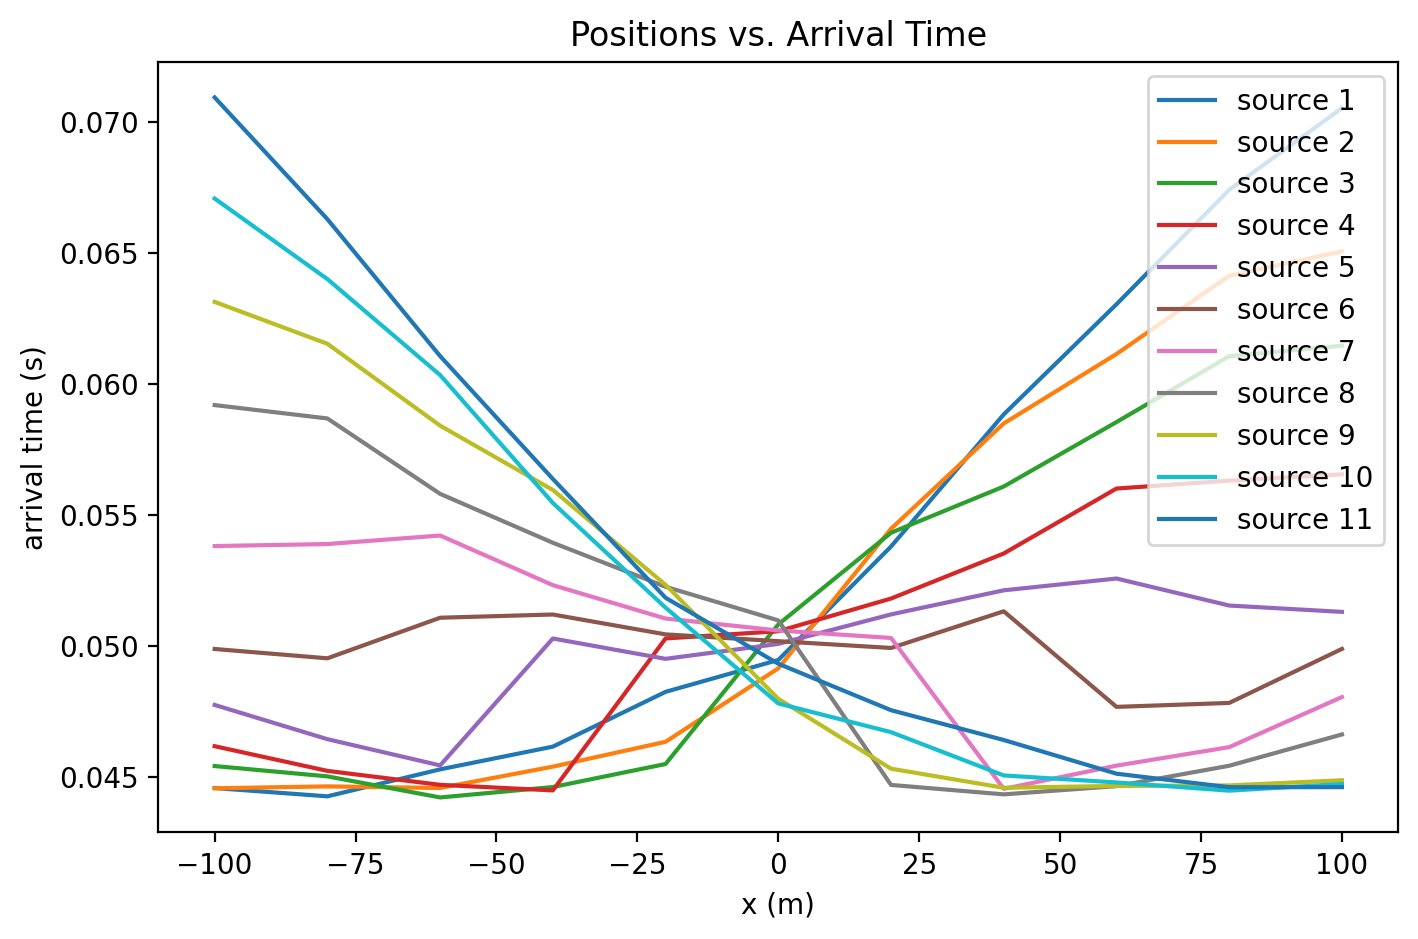

In [3]:
dobs = np.loadtxt(str(data_filename))

xy_sources = dobs[:, 0:2]
xy_receivers = dobs[:, 2:4]
dobs = dobs[:, -1]

# Define survey
unique_sources, k = np.unique(xy_sources, axis=0, return_index=True)
n_sources = len(k)
k = np.r_[k, len(dobs) + 1]

source_list = []
for ii in range(0, n_sources):
    # Receiver locations for source ii
    receiver_locations = xy_receivers[k[ii] : k[ii + 1], :]
    receiver_list = [tomo.Rx(receiver_locations)]

    # Source ii location
    source_location = xy_sources[k[ii], :]
    source_list.append(tomo.Src(receiver_list, source_location))

# Define survey
survey = tomo.Survey(source_list)

# Define a data object. Uncertainties are added later
data_obj = data.Data(survey, dobs=dobs)

# Plot
n_source = len(source_list)
n_receiver = len(xy_receivers)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
obs_string = []

for ii in range(0, n_source):
    x_plotting = xy_receivers[k[ii] : k[ii + 1], 0]
    dobs_plotting = dobs[k[ii] : k[ii + 1]]
    ax.plot(x_plotting, dobs_plotting)
    obs_string.append("source {}".format(ii + 1))

ax.set_xlabel("x (m)")
ax.set_ylabel("arrival time (s)")
ax.set_title("Positions vs. Arrival Time")
ax.legend(obs_string, loc="upper right")

plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define standard deviation on our data.
This represents our estimate of the noise in our data. In this case, we
assign a 5 percent uncertainty to each datum.




In [4]:
# Compute standard deviations
std = 0.05 * np.abs(dobs)

# Add standard deviations to data object
data_obj.standard_deviation = std

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to invert the data.




In [5]:
# dh = 50.0  # cell width
# N = 100  # number of cells in X and Y direction
# hx = [(dh, N)]
# hy = [(dh, N)]
# mesh = TensorMesh([hx, hy], "CC")
dh = 10.0  # cell width
N = 21  # number of cells in X and Y direction
hx = [(dh, N)]
hy = [(dh, N)]
mesh = TensorMesh([hx, hy], "CC")

## Starting/Reference Model and Mapping on Tensor Mesh

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the slowness. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the background is 3000 m/s.




In [6]:
# Define density contrast values for each unit in g/cc. Don't make this 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.
background_velocity = 4500.0

# Define mapping from model space to the slowness on mesh cells
model_mapping = maps.ReciprocalMap()

# Define starting model
starting_model = background_velocity * np.ones(mesh.nC)

## Define the Physics

Here, we define the physics of the 2D straight ray tomography problem by
using the simulation class.




In [7]:
# Define the forward simulation. To do this we need the mesh, the survey and
# the mapping from the model to the slowness value on each cell.
simulation = tomo.Simulation(mesh, survey=survey, slownessMap=model_mapping)

## Define the Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem




In [8]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_obj, simulation=simulation)

# Define the regularization (model objective function). Here, 'p' defines the
# the norm of the smallness term and 'q' defines the norm of the smoothness
# term.
reg = regularization.Sparse(mesh, mapping=maps.IdentityMap(nP=mesh.nC))
p = 0
qx = 0.5
qy = 0.5
reg.norms = [p, qx, qy]

# Define how the optimization problem is solved.
opt = optimization.ProjectedGNCG(
    maxIter=500, lower=0.0, upper=1e6, maxIterLS=20, maxIterCG=50, tolCG=1e-4
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [9]:
# Reach target misfit for L2 solution, then use IRLS until model stops changing.
update_IRLS = directives.UpdateIRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    irls_cooling_factor=1.5,
    misfit_tolerance=1e-2,
)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=2e0)

# Save output at each iteration
saveDict = directives.SaveOutputEveryIteration(save_txt=False)

# Define the directives as a list
directives_list = [starting_beta, update_IRLS, saveDict]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [10]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)

/Users/guntas13/micromamba/envs/sttPy10/lib/python3.10/site-packages/simpeg/directives/directives.py:342: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `directives.UpdatePreconditioner` to your directives list
  [directive.validate(self) for directive in self.dList]
/Users/guntas13/micromamba/envs/sttPy10/lib/python3.10/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.59e-08  2.56e+02  5.24e-21  2.56e+02    6.83e-02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 816.6048853467428
   1  1.59e-08  2.71e+01  4.57e+09  9.98e+01    1.81e-02      0              
   2  3.22e-08  2.87e+01  4.65e+

## Plotting True Model and Recovered Model




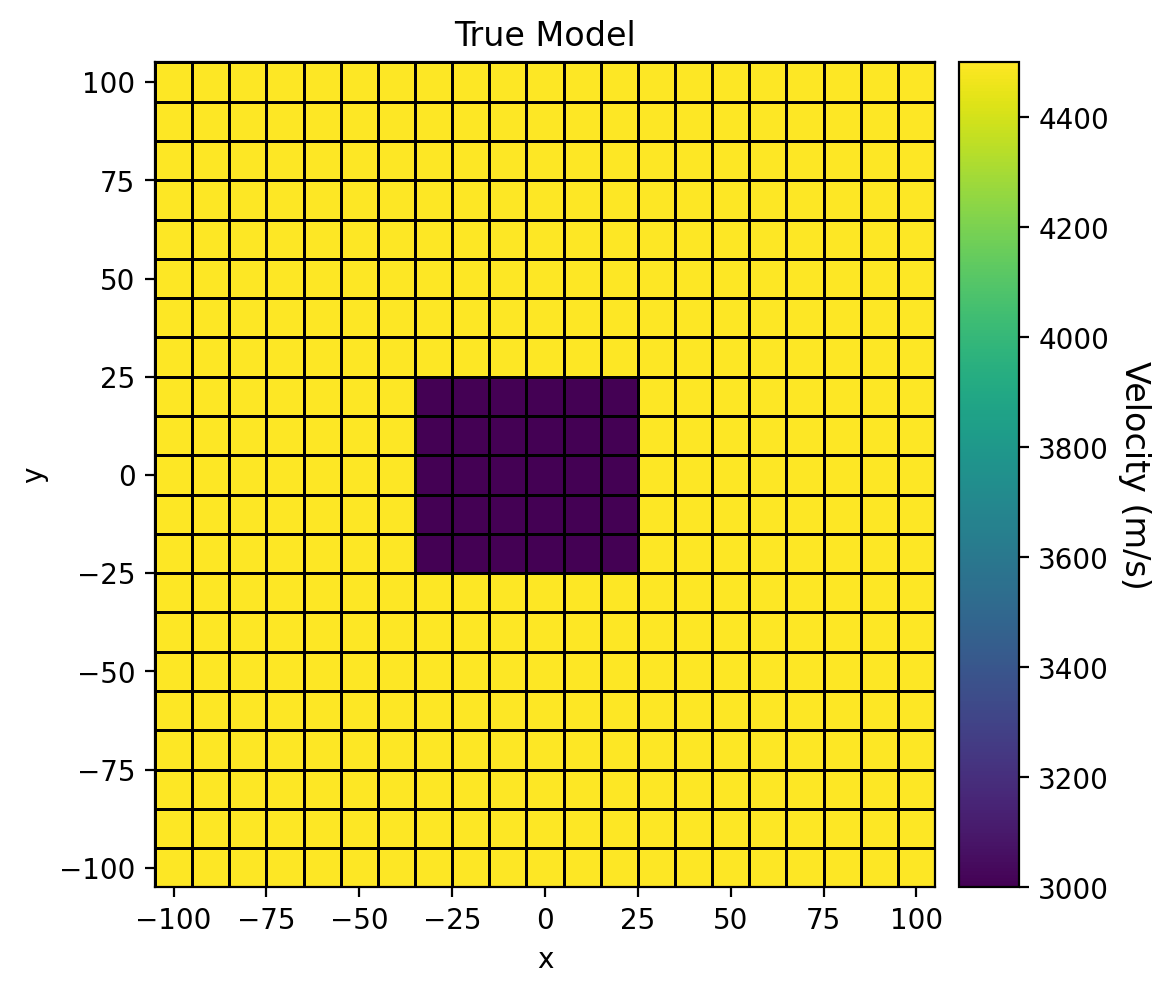

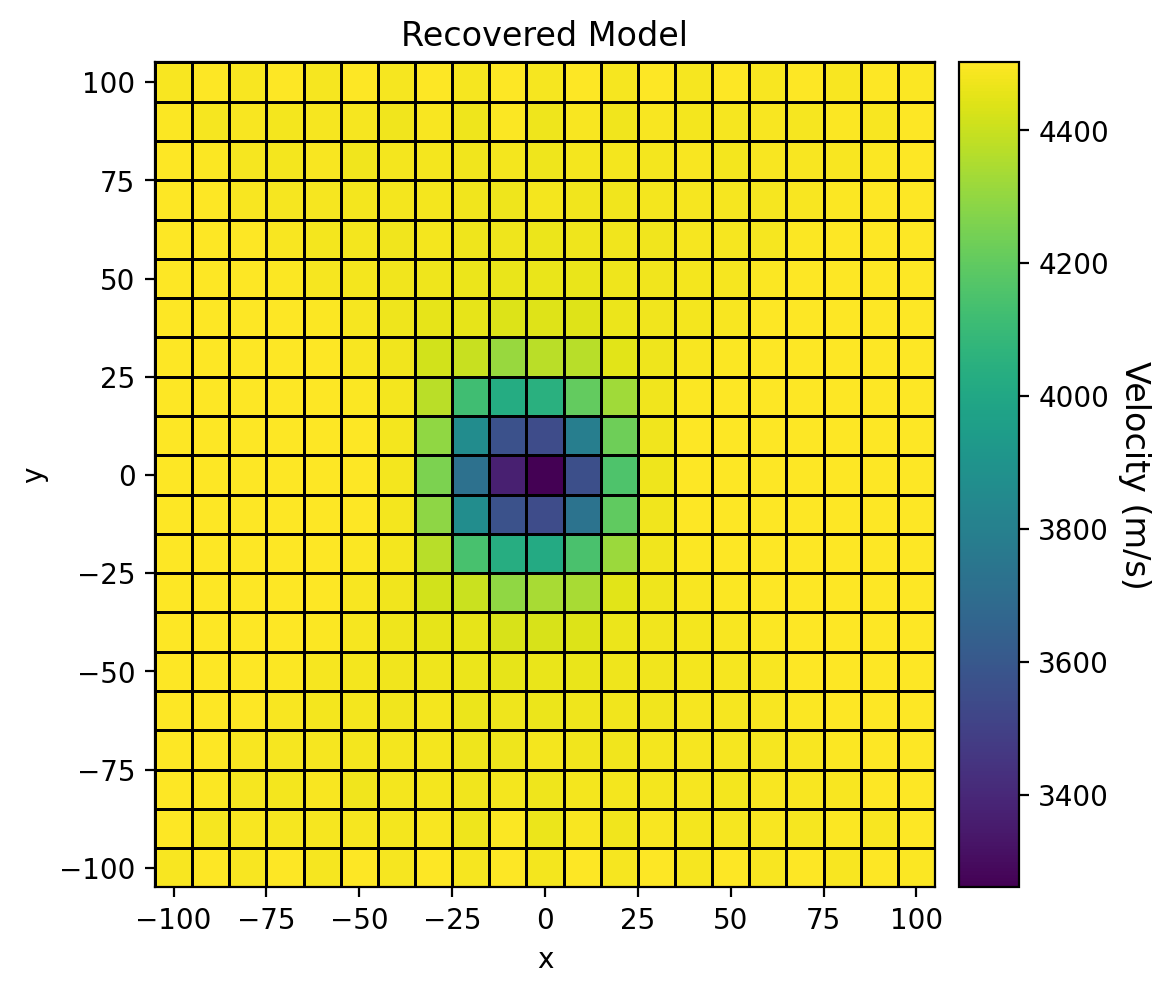

In [11]:
true_model = np.loadtxt(str(model_filename))

fig = plt.figure(figsize=(6, 5.5))
ax1 = fig.add_axes([0.15, 0.15, 0.65, 0.75])
mesh.plot_image(true_model, ax=ax1, grid=True, pcolor_opts={"cmap": "viridis"})
ax1.set_title("True Model")

ax2 = fig.add_axes([0.82, 0.15, 0.05, 0.75])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("Velocity (m/s)", rotation=270, labelpad=15, size=12)
plt.show()

fig = plt.figure(figsize=(6, 5.5))
ax1 = fig.add_axes([0.15, 0.15, 0.65, 0.75])
mesh.plot_image(recovered_model, ax=ax1, grid=True, pcolor_opts={"cmap": "viridis"})
ax1.set_title("Recovered Model")

ax2 = fig.add_axes([0.82, 0.15, 0.05, 0.75])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("Velocity (m/s)", rotation=270, labelpad=15, size=12)
plt.show()